# Importing the Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


from keras.preprocessing import image
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l1, l2


# from keras.src.applications import InceptionResNetV2
from keras.src.applications.inception_resnet_v2 import preprocess_input

import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


2024-03-14 08:43:40.000501: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 08:43:41.263108: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-14 08:43:44.364567: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 08:43:47.943109: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Creating a Combined Image Dataset with Labels

In [2]:
data_dir = "Eye Disease dataset"

cataract_df = pd.DataFrame(columns=['filepaths', 'labels'])
diabetic_retinopathy_df = pd.DataFrame(columns=['filepaths', 'labels'])
glaucoma_df = pd.DataFrame(columns=['filepaths', 'labels'])
normal_df = pd.DataFrame(columns=['filepaths', 'labels'])

cataract_label = 'cataract'
diabetic_retinopathy_label = 'diabetic_retinopathy'
glaucoma_label = 'glaucoma'
normal_label = 'normal'


cataract_files = os.listdir(os.path.join(data_dir, "cataract"))
diabetic_retinopathy_files = os.listdir(os.path.join(data_dir, "diabetic_retinopathy"))
glaucoma_files = os.listdir(os.path.join(data_dir, "glaucoma"))
normal_files = os.listdir(os.path.join(data_dir, "normal"))


cataract_df['filepaths'] = [os.path.join(data_dir, "cataract", filename) for filename in cataract_files]
cataract_df['labels'] = cataract_label

diabetic_retinopathy_df['filepaths'] = [os.path.join(data_dir, "diabetic_retinopathy", filename) for filename in diabetic_retinopathy_files]
diabetic_retinopathy_df['labels'] = diabetic_retinopathy_label

glaucoma_df['filepaths'] = [os.path.join(data_dir, "glaucoma", filename) for filename in glaucoma_files]
glaucoma_df['labels'] = glaucoma_label

normal_df['filepaths'] = [os.path.join(data_dir, "normal", filename) for filename in normal_files]
normal_df['labels'] = normal_label

In [4]:
combined_df = pd.concat([cataract_df, diabetic_retinopathy_df], ignore_index=True)
combined_df = pd.concat([combined_df, glaucoma_df], ignore_index=True)
combined_df = pd.concat([combined_df, normal_df], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=42)
label_counts = combined_df['labels'].value_counts()

label_counts

labels
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [5]:
combined_df.head()

,filepaths,labels
463,Eye Disease dataset/cataract/2211_right.jpg,cataract
2426,Eye Disease dataset/glaucoma/_223_380742.jpg,glaucoma
2661,Eye Disease dataset/glaucoma/_338_7660594.jpg,glaucoma
1483,Eye Disease dataset/diabetic_retinopathy/10458...,diabetic_retinopathy
2860,Eye Disease dataset/glaucoma/_60_3287251.jpg,glaucoma


# Exploring Data Distribution and Visualizing Images

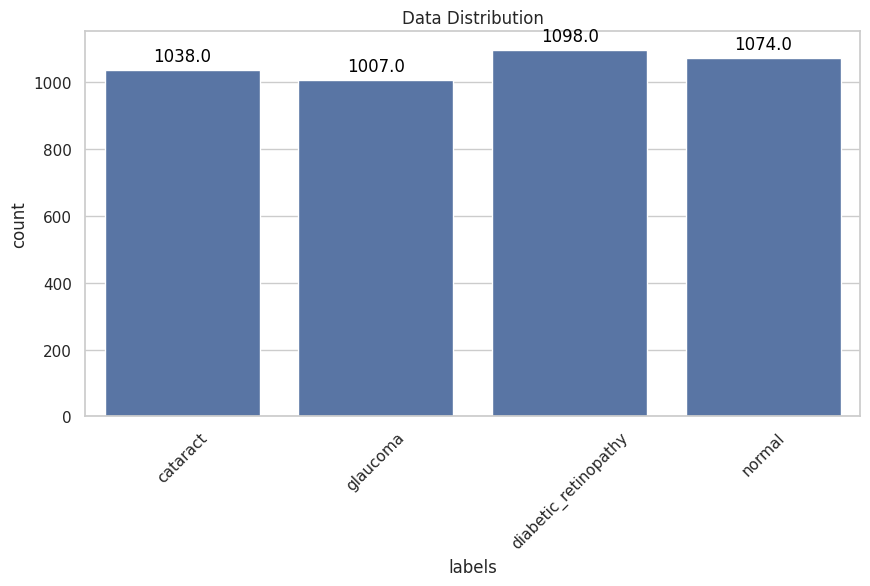

In [6]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.countplot(data=combined_df, x='labels')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')

plt.title('Data Distribution')
plt.xticks(rotation=45)
plt.show()

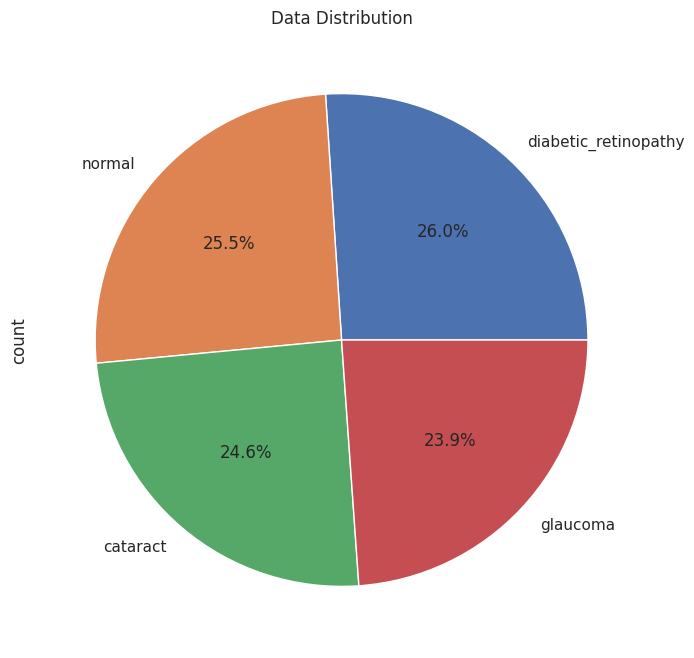

In [7]:
plt.figure(figsize=(10, 8))
combined_df['labels'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

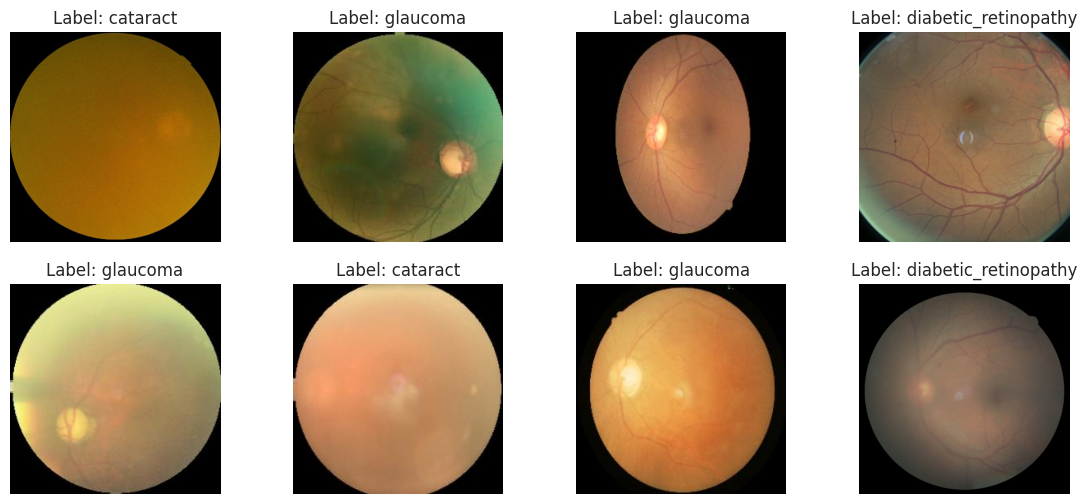

In [8]:
def display_images(df, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6))
    for r in range(rows):
        for c in range(cols):
            index = r * cols + c
            if index < len(df):
                image_path = df.iloc[index]['filepaths']
                label = df.iloc[index]['labels']
                img = Image.open(image_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f'Label: {label}')
                axes[r, c].axis('off')
            else:
                axes[r, c].axis('off')

    plt.show()

rows = 2
cols = 4

display_images(combined_df, rows, cols)

# Data Splitting and Class Distribution in Image Dataset

In [9]:
train_df, dummy_df = train_test_split(combined_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= combined_df['labels'])

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= dummy_df['labels'])

In [10]:
train_df['labels'].value_counts()

labels
diabetic_retinopathy    878
normal                  859
cataract                830
glaucoma                806
Name: count, dtype: int64

In [11]:
test_df['labels'].value_counts()

labels
diabetic_retinopathy    110
normal                  107
cataract                104
glaucoma                101
Name: count, dtype: int64

In [13]:
valid_df['labels'].value_counts()

labels
diabetic_retinopathy    110
normal                  108
cataract                104
glaucoma                100
Name: count, dtype: int64

# Data Preprocessing and Generation

In [14]:
def scalar(img):
        return img

train_generator = ImageDataGenerator(preprocessing_function = scalar,
                                     horizontal_flip = True)

test_generator = ImageDataGenerator(preprocessing_function = scalar)
     

In [15]:
train_set = train_generator.flow_from_dataframe( train_df,
                                        x_col= 'filepaths',
                                        y_col= 'labels',
                                        target_size= (224, 224),
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= 40)

Found 3373 validated image filenames belonging to 4 classes.


In [16]:
train_set.class_indices

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

In [17]:
valid_set = test_generator.flow_from_dataframe( valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= (224, 224),
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= 40)

Found 422 validated image filenames belonging to 4 classes.


In [18]:
test_set = test_generator.flow_from_dataframe( test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (224, 224),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= 2)

Found 422 validated image filenames belonging to 4 classes.


# Deep Learning Models
# Transfer Learning(TL)
# InceptionResNetV2-based Neural Network Architecture

In [17]:
# base_model = InceptionResNetV2(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')

# x = base_model.output
# x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

# x = Dense(256, kernel_regularizer=l2(l=0.016), activity_regularizer=l1(0.006), bias_regularizer=l1(0.006), activation='relu')(x)
# x = Dropout(rate=0.3)(x)

# output = Dense(4, activation='softmax')(x)

# model = Model(inputs = base_model.input, outputs = output)

# model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.load_weights("/kaggle/input/weights/efficientnetb3_notop.h5")
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

output = Dense(4, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,572,531 (44.15 MB)

 Trainable params: 788,996 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

# Training the Model

In [18]:
history = model.fit(x= train_set,
                    epochs= 20,
                    verbose= 1,
                    validation_data= valid_set
)

Epoch 1/20


2024-03-13 14:04:22.914426: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.
2024-03-13 14:04:23.348721: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.
2024-03-13 14:04:23.544665: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.
2024-03-13 14:04:23.683302: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.
2024-03-13 14:04:23.977372: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.


85/85 ━━━━━━━━━━━━━━━━━━━━ 307s 3s/step - accuracy: 0.6561 - loss: 5.5744 - val_accuracy: 0.7630 - val_loss: 1.4426
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.7626 - loss: 1.1977 - val_accuracy: 0.7891 - val_loss: 0.9384
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.7777 - loss: 0.8524 - val_accuracy: 0.7725 - val_loss: 0.8128
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.7762 - loss: 0.7899 - val_accuracy: 0.7962 - val_loss: 0.7387
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.7976 - loss: 0.6922 - val_accuracy: 0.8128 - val_loss: 0.6812
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.7973 - loss: 0.6863 - val_accuracy: 0.8318 - val_loss: 0.6492
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 324s 3s/step - accuracy: 0.8091 - loss: 0.6534 - val_accuracy: 0.8223 - val_loss: 0.6617
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.7839 - loss: 0.6895 - val_accuracy: 0.8057 - val_loss: 0.

# Training and Validation Performance Visualization

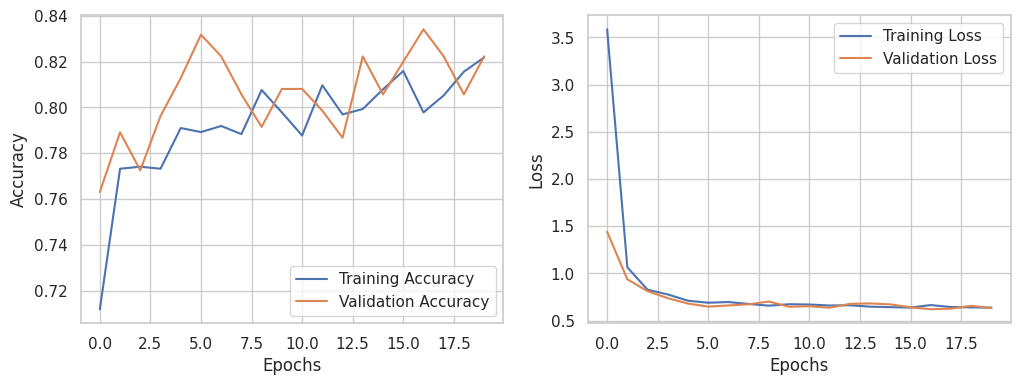

In [19]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Model Saving

In [25]:
# model.save("EfficientNetB3.h5")
model.save('my_model.keras')


# Model Loading

In [19]:
model = load_model("my_model.keras")

In [25]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

2024-03-13 16:57:52.267290: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.
2024-03-13 16:57:52.342303: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24084480 exceeds 10% of free system memory.
2024-03-13 16:57:52.354378: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24300000 exceeds 10% of free system memory.
2024-03-13 16:57:52.360395: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80281600 exceeds 10% of free system memory.
2024-03-13 16:57:52.683744: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80281600 exceeds 10% of free system memory.


 7/85 ━━━━━━━━━━━━━━━━━━━━ 3:58 3s/step - accuracy: 0.8270 - loss: 0.6738

KeyboardInterrupt: 

In [30]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

211/211 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.97      0.73      0.84       104
diabetic_retinopathy       0.99      0.79      0.88       110
            glaucoma       0.69      0.76      0.72       101
              normal       0.70      0.94      0.80       107

            accuracy                           0.81       422
           macro avg       0.84      0.81      0.81       422
        weighted avg       0.84      0.81      0.81       422



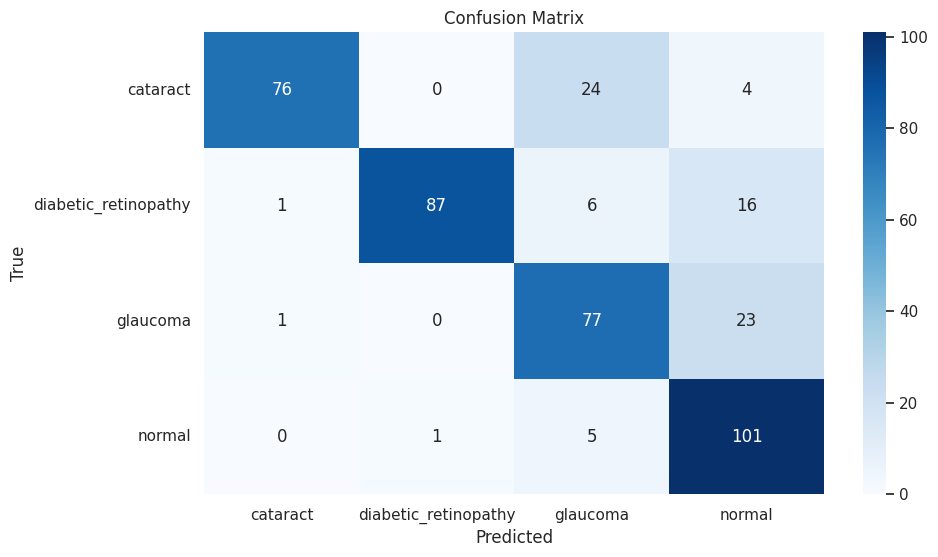

In [31]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


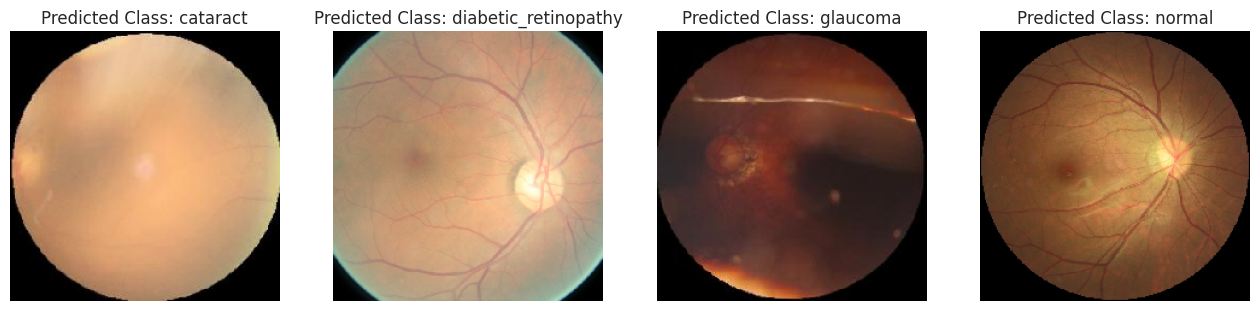

In [20]:
def predict_and_display_images(image_paths, model):
    class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    'Eye Disease dataset/cataract/_1_5346540.jpg',
    'Eye Disease dataset/diabetic_retinopathy/119_left.jpeg',
    'Eye Disease dataset/glaucoma/_9_9966988.jpg',
    'Eye Disease dataset/normal/951_right.jpg'
]

predict_and_display_images(image_paths, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


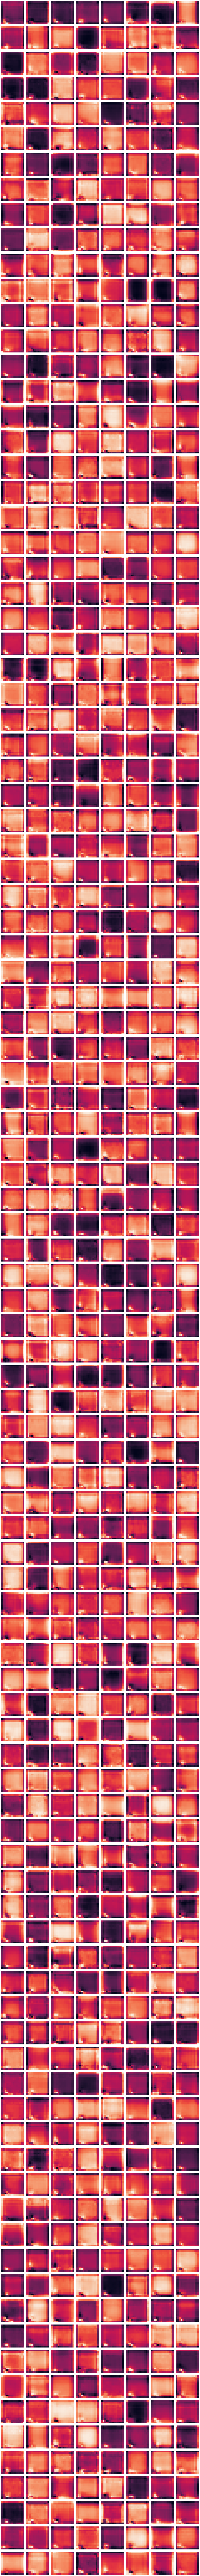

In [22]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# layer_name ='conv2d_148'
layer_name = 'block5e_expand_conv' 
img_path = 'Eye Disease dataset/glaucoma/_9_9966988.jpg'

visualize_activation_maps(model, img_path, layer_name)